In [1]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt

## 1. Get the Data

In [2]:
df = pd.read_csv("airline_passengers.csv" , index_col = "Month" , parse_dates = True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Thousands of Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [4]:
df.index.freq = 'MS'

In [5]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [6]:
df.tail()

# So evertything after dec-1960 is future

,Thousands of Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


## 2. Test -Train Split

In [7]:
len(df)

144

In [8]:
train_data = df.iloc[:109]  # 9yrs  = 108 months
test_data = df.iloc[108:]   # 3yrs  = 36  months

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [10]:
fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'],
                                   trend = 'mul',
                                   seasonal = 'mul',
                                   seasonal_periods = 12).fit()

C:\Users\aakas\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


## 3. Predictions into the futures : 36 months

In [11]:
predictions = fitted_model.forecast(36)

In [12]:
predictions[:5]

1958-02-01    339.142929
1958-03-01    399.281670
1958-04-01    394.233619
1958-05-01    402.545275
1958-06-01    473.128728
Freq: MS, dtype: float64

## 4. Plotting

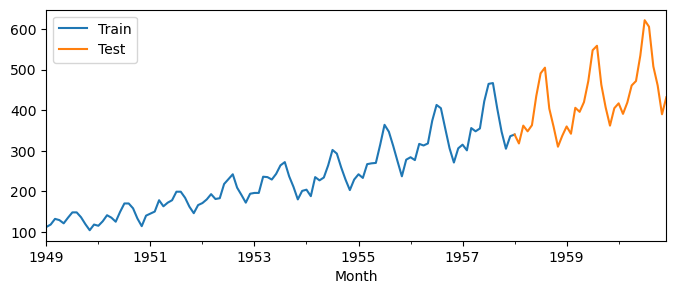

In [13]:
train_data['Thousands of Passengers'].plot(legend = True , label = 'Train' , 
                                           figsize = (8,3))

test_data['Thousands of Passengers'].plot(legend = True , label = 'Test')

plt.show()

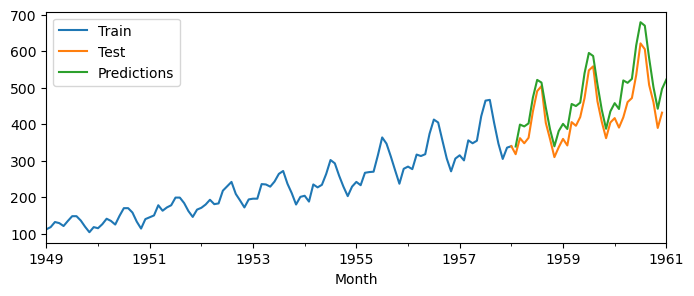

In [14]:
train_data['Thousands of Passengers'].plot(legend = True , label = 'Train' , 
                                           figsize = (8,3))

test_data['Thousands of Passengers'].plot(legend = True , label = 'Test')

predictions.plot(legend = True , label = 'Predictions')

plt.show()

# df.rename_axis('names')  : for renaming the name of index or data column of a DF 
#                            (by default axis = 0)

## 5. Evaluation

In [15]:
test_data.describe()

,Thousands of Passengers
count,36.000000
mean,428.500000
std,79.329152
min,310.000000
25%,362.000000
50%,412.000000
75%,472.000000
max,622.000000


In [16]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [17]:
test_data.size

36

In [18]:
predictions.size

36

In [19]:
MAE = mean_absolute_error(test_data,predictions)
MAE

63.031171575091825

In [20]:
MSE = mean_squared_error(test_data ,predictions)
MSE

5614.266734155986

In [21]:
RMSE = np.round(np.sqrt(MSE),3)
RMSE
# less than the Standard deviation , so we are predicting good if not perfect.

74.928

## 6. Final model

In [22]:
# fitting on the complete data
final_model = ExponentialSmoothing(df['Thousands of Passengers'],
                                  trend = 'mul',
                                  seasonal = 'mul',
                                  seasonal_periods = 12).fit()

C:\Users\aakas\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [23]:
# forecasting 36 months into the future (that we donot know)
forecast_predictions = final_model.forecast(36)

## 7. Plotting

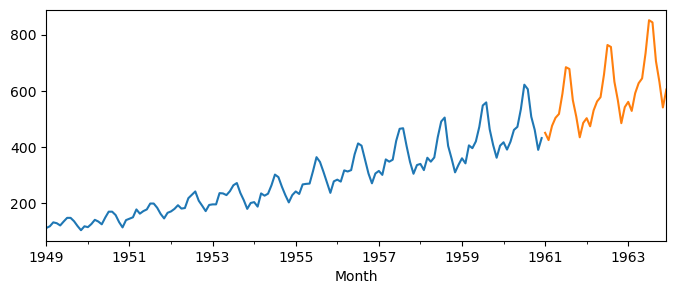

In [24]:
df['Thousands of Passengers'].plot(figsize = (8,3))
forecast_predictions.plot()
plt.show()

## 8. Stationarity and Non-stationarity of Timeseries data

- **Stationarity** : **no trend** or **seasonality** component is present.
                 <br> That is, the **mean**, **variance** and **covariance** should be the same for any                      segment of the series, and are not functions of time.
<br> 

- **Non-stationarity** : trend and/or seasonality component is present.

In [48]:
df2 = pd.read_csv('samples.csv' , index_col = 0 , parse_dates = True)

In [49]:
df2.head(2)

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31


#### (i) Stationary time-series data

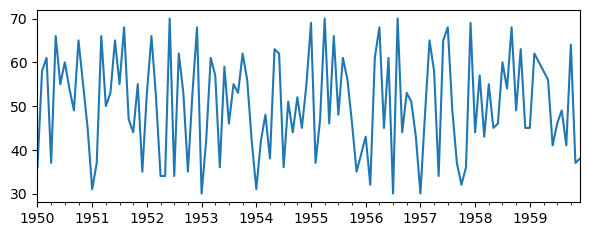

In [27]:
df2['a'].plot(figsize = (7,2.5))
plt.show()

#### (ii)  Non-stationary time series data

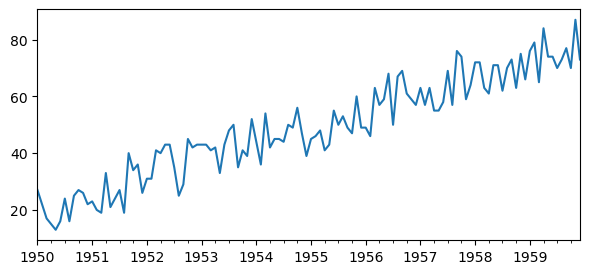

In [28]:
df2['b'].plot(figsize = (7,3))
plt.show()

# trend : upward
# seasonality : hard to find if any.

## 9. Differencing method

- Non-stationary data can be made to look stationary through differencing.

### (i) First Order Differencing
A simple method called <em>first order differencing</em> calculates the difference between consecutive observations.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

In this way a linear trend is transformed into a horizontal set of values.

<div class="alert alert-info"><strong>NOTE: </strong>This is different from <font color=black><tt>df2['c'].diff(2)</tt></font>, which would provide a first order difference spaced 2 lags apart.<br>
We'll use this technique later to address seasonality.</div>

#### (a) First Approach : Using shift() method

In [29]:
# Calculate the first difference of the non-stationary dataset "b"

df2['b'].shift(1).head(5)

1950-01-01     NaN
1950-02-01    27.0
1950-03-01    22.0
1950-04-01    17.0
1950-05-01    15.0
Name: b, dtype: float64

In [30]:
D1 = df2['b'] - df2['b'].shift(1)
D1.head(5)

1950-01-01    NaN
1950-02-01   -5.0
1950-03-01   -5.0
1950-04-01   -2.0
1950-05-01   -2.0
Name: b, dtype: float64

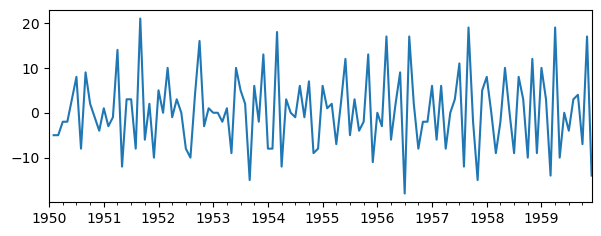

In [31]:
D1.plot(figsize = (7,2.5))
plt.show()

#### (b) Second Approach : In-built diff() method of pandas

In [32]:
D2 = df2['b'].diff()

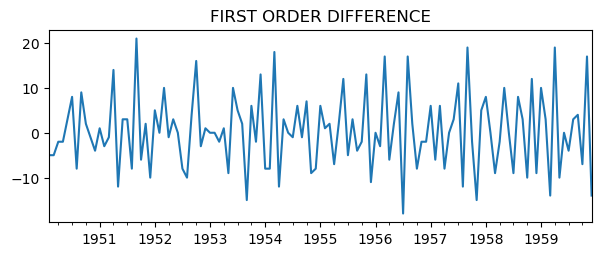

In [33]:
D2.plot(title="FIRST ORDER DIFFERENCE" , figsize = (7,2.5)).autoscale(axis='x',tight=True);

#### (c) Third Approach : Using Diff() method in statsmodels

In [34]:
from statsmodels.tsa.statespace.tools import diff

In [35]:
D3 = diff(df2['b'] , k_diff = 1)
D3

# K_diff : int (optional) 
#          The number of simple differences to perform. 
#          Default is 1.

# seasonal_diff : int or None (optional)

#                 The number of seasonal differences to perform. 
#                 Default is no seasonal differencing.

1950-02-01    -5.0
1950-03-01    -5.0
1950-04-01    -2.0
1950-05-01    -2.0
1950-06-01     3.0
              ... 
1959-08-01     3.0
1959-09-01     4.0
1959-10-01    -7.0
1959-11-01    17.0
1959-12-01   -14.0
Name: b, Length: 119, dtype: float64

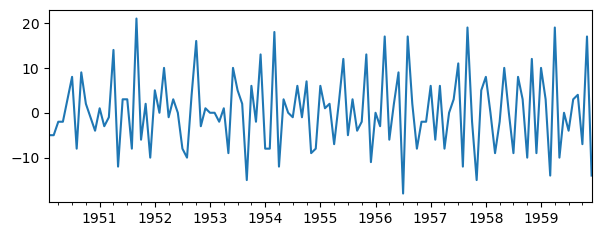

In [36]:
D3.plot(figsize = (7,2.5))
plt.show()

### (ii) Second order differencing
Sometimes the first difference is not enough to attain stationarity, particularly if the trend is not linear. We can difference the already differenced values again to obtain a second order set of values.

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_{t}^{\prime} - y_{t-1}^{\prime} \\
&= (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) \\
&= y_t - 2y_{t-1} + y_{t-2}\end{split}$

#### Forecasting on second order differenced data
As before, the prediction values have to be added back in to obtain an appropriate forecast.

To invert the second order transformation and obtain forecasted values for $\hat y_t$ we have to solve the second order equation for $y_t$:

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_t - 2y_{t-1} + y_{t-2} \\
y_t &= y_{t}^{\prime\prime} + 2y_{t-1} - y_{t-2}\end{split}$

Let's say that the next five forecasted values after applying some model to <tt>df['d2c']</tt> are <tt>[7,-2,5,-1,12]</tt>.

In [37]:
# For our example we need to build a forecast series from scratch

idx = pd.date_range('1960-01-01', periods=5, freq='MS')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])
z

,Fcast
1960-01-01,7
1960-02-01,-2
1960-03-01,5
1960-04-01,-1
1960-05-01,12


#### (a) First Approach : To invert a 2nd order transformation by using above formula.

In [38]:
df2['c'].tail()

1959-08-01     9338
1959-09-01     9502
1959-10-01     9667
1959-11-01     9833
1959-12-01    10000
Name: c, dtype: int64

In [39]:
df2['c'].iloc[-2:]

1959-11-01     9833
1959-12-01    10000
Name: c, dtype: int64

In [40]:
t_2 , t_1 = df2['c'].iloc[-2:]

In [41]:
t_2 , t_1

(9833, 10000)

In [42]:
trans_val_list = []

for i in z['Fcast']:
    
    # Using Formula : yt = 𝑦′′𝑡 + 2𝑦𝑡−1 − 𝑦𝑡−2
    trans_val = i + 2*t_1 - t_2
    
    trans_val_list.append(trans_val)
    t_2 , t_1 = t_1 , trans_val
    
z["Forecast"] = trans_val_list
z

,Fcast,Forecast
1960-01-01,7,10174
1960-02-01,-2,10346
1960-03-01,5,10523
1960-04-01,-1,10699
1960-05-01,12,10887


#### (b) Second Appraoch :

- to create a first difference set from the second difference, then build the forecast set from the first difference.

In [43]:
z['Fcast'].cumsum()

1960-01-01     7
1960-02-01     5
1960-03-01    10
1960-04-01     9
1960-05-01    21
Freq: MS, Name: Fcast, dtype: int64

In [44]:
(df2['c'].iloc[-1]-df2['c'].iloc[-2])

167

#### Go through the below equations 

In [45]:
###### First order Difference ######
#  y'(t) = y(t)  - y(t-1)    ........ eq1
#  y"(t) = y'(t) - y'(t-1)   ........ eq2

# and , y'(t-1) = y(t-1) - y(t-2)   ...... eq3

# from eq2 , we have
# y'(t) = y"(t) + y'(t-1)      ....... eq4

# substituting eq3 in eq4 , we get

# y'(t) = y"(t) + y(t-1) - y(t-2)    ...... eq5

# example (i) : for value Fcast = 7

# y(t-1) - y(t-2) = (df2['c'].iloc[-1]-df2['c'].iloc[-2]) = 167
# y''(t) = 7
# therefore , firstdiff  = 7 + 167 = 174


# example 2 : for value Fcast = -2

# y"(t)  =  -2
# firstdiff =  -2 + y'(t-1)    (from equation 2 : y'(t) = y"(t) + y'(t-1)  )
# firstdiff =  -2 + 7 + 167   =  cumsum(f"(t)) + (df2['c'].iloc[-1]-df2['c'].iloc[-2])



##### forecast from first order Difference #######

# forecast y(t) = y'(t) - y(t-1)


In [46]:
# Add the most recent first difference from the training set to the Fcast cumulative sum
z['firstdiff'] = (df2['c'].iloc[-1]-df2['c'].iloc[-2]) + z['Fcast'].cumsum()

# Now build the forecast values from the first difference set
z['forecast'] = df2['c'].iloc[-1] + z['firstdiff'].cumsum()

z[['Fcast','firstdiff','forecast']]

,Fcast,firstdiff,forecast
1960-01-01,7,174,10174
1960-02-01,-2,172,10346
1960-03-01,5,177,10523
1960-04-01,-1,176,10699
1960-05-01,12,188,10887


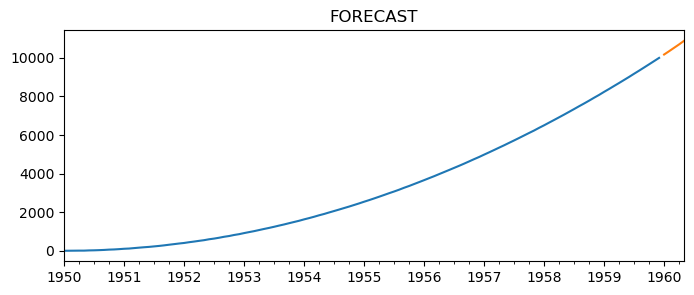

In [47]:
df2['c'].plot(figsize=(8,3), title="FORECAST").autoscale(axis='x',tight=True)

z['forecast'].plot();

## 10. Lagging

- Also known as **backshifting** lagging notation reflects the value of **𝑦**
  at a prior point in time. 

- 𝐿(𝑦) = 𝑦(𝑡−1)       :   one lag shifts the data back one period

  𝑦(𝑡−1)  = y(t).shift(1) <br>

<br>

- L^2(y(t)) = 𝑦(𝑡−2)  :   two lags shift the data back two periods

    𝑦(𝑡−2)  = y(t).shift(2)